# SmartBay observatory: Underwater acoustics data analysis

The SmartBay Observatory is installed on the seafloor 1.5 km off the coast of Spiddal, Co. Galway, Ireland. The observatory uses cameras, probes and sensors to continuously monitor underwater conditions [(Gaughan 2019)](https://agris.fao.org/agris-search/search.do?recordID=QN2019000000146). The datasets include acoustic data collected using an icListen HF Smart Hydrophone – a digital hydrophone that processes and stores acoustic data. The hydrophone is approx. 25 m depth of water @ 53° 13.640'N 9° 15.979'W. The data provided includes the processed FFT files, stored in a txt format generated once a minute with a reading every second. The metadata is included in the header of the text file. The processed files are available in real-time via:http://smartbay.marine.ie/data/hydrophones/

<img src="https://i5tug39ogig2h2u30cvaov17-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/QPI_6666-1-960x960.jpg" width="300">

In [1]:
%%html
"<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d200569.66507237506!2d-9.476590181413934!3d53.17169577268737!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0x0!2zNTPCsDEzJzM4LjQiTiA5wrAxNSc1OC43Ilc!5e0!3m2!1sen!2sie!4v1634741858773!5m2!1sen!2sie" width="600" height="450" style="border:0;" allowfullscreen="" loading="lazy"></iframe>"

In this notebook, we present some codes to download, read and analyze the SmartBay hydrophones data. The main goal is trying to observe any feature related to wind and wave breaking. Let's start importing the required libraries

In [20]:
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
from helpers import SmartBayHydrophone
import os

plt.rcParams["figure.dpi"] = 120
plt.rcParams['pcolor.shading'] = "auto"

The data provided by SmartBay consists of ambient noise spectrograms, which have been processed using the traditional Fast Fourier Transform using 1024 points with a overlap of 50% and tapered with a Hann window. The sampling frequency varies from 64 to 512 kHz, so does the bin width from 62.5 Hz to 512 Hz. According to the metadata, the reference units are **dB Ref re 1V -120** and **dB Ref re 1uPa 51**.

## Typical day of underwater noise

The module `helpers.py` contains a class called `SmartBayHydrophone` to download, read and interact with the data for a given day. Let's see for example what the spectrogram looked like for Aug 12th, 2020.

In [5]:
date = dt.date(2020, 8, 12)
hydro = SmartBayHydrophone(date, "SBF1622")
hydro.download()

<xarray.DataArray (time: 85878, frqs: 410)>
[35209980 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2020-08-12 ... 2020-08-12T23:59:59
  * frqs     (frqs) float64 0.0 62.5 125.0 ... 2.544e+04 2.55e+04 2.556e+04

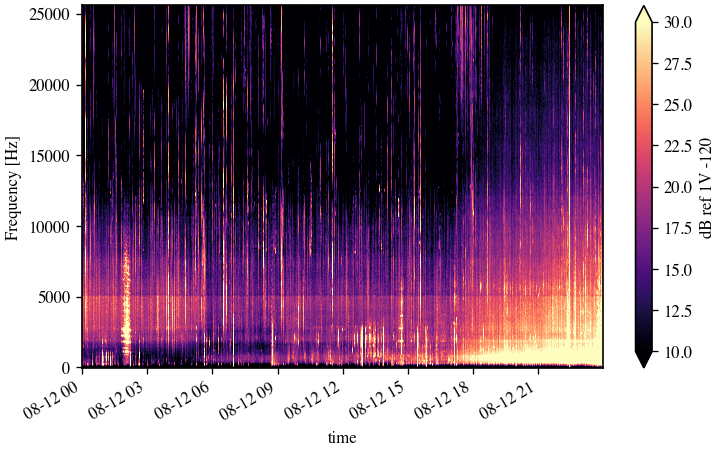

In [9]:
fig, ax = hydro.plot_spectrogram(vmin=10, vmax=30)

It is interesting to notice the vertical stripes occurring with a certain periodicity and that spreads almost all over the frequencies. It is really difficult to know what these stripes are owing to. They could be related to the sound produced by biological activity, noise due to a nearby structure like the chain in the mooring, or perhaps underwater bubbles produced by breaking waves. It is interesting as well the clear increment in the low frequency noise noticeable from 18hrs on. This is presumably produced by an increase in the wind speed as we are going to see later. Additionally, there is an interesting noise signature occurring around 02:00 am. Let's have a deeper look at it.

(0.0, 10000.0)

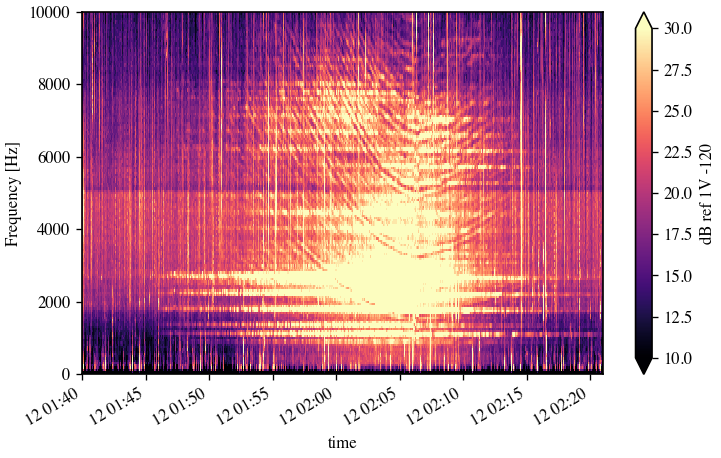

In [10]:
fig, ax = hydro.plot_spectrogram(zoom=slice("2020-08-12 01:40", "2020-08-12 02:20"))
ax.set_ylim([0, 10000])

This noise is characterised by some horizontal stripes localized in certain frequencies between 1 and 3 kHz. Also, it is noticeable the parabolic shape occurring in form of different harmonics. This could be a typical signature of whales singing or perhaps a vessel passing by.

## Noise spectrum as function of wind speed

Knudsen curves [Kurahashi](https://arxiv.org/pdf/0712.1833.pdf)

In [37]:
DATA_PATH = os.path.expanduser("~/Workspace/data/smartbay/")

# load wind dataset
wind = xr.open_dataset(DATA_PATH + "meteorological/era5-wind-speed.nc")

# load spectrograms
ds = xr.open_mfdataset(DATA_PATH + "hydrophone/hourly/*.nc")
ds = ds.rename({"__xarray_dataarray_variable__": "spec"})
ds["wspd"] = wind["wspd"]
ds["wdir"] = wind["wdir"]

ds

<xarray.Dataset>
Dimensions:  (frqs: 410, time: 5974)
Coordinates:
  * time     (time) datetime64[ns] 2019-10-01 ... 2020-08-12T23:00:00
  * frqs     (frqs) float64 0.0 62.5 125.0 ... 2.544e+04 2.55e+04 2.556e+04
Data variables:
    spec     (time, frqs) float64 dask.array<chunksize=(24, 410), meta=np.ndarray>
    wspd     (time) float64 ...
    wdir     (time) float64 ...

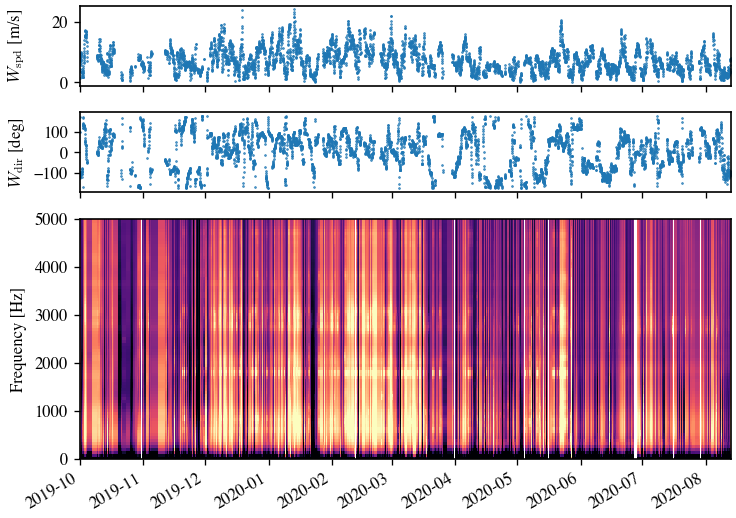

In [199]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(7,5), gridspec_kw={"height_ratios": [1,1,3]}, sharex=True
)

ds["wspd"].plot(ax=ax1, marker=".", lw=0, ms=1)
ds["wdir"].plot(ax=ax2, marker=".", lw=0, ms=1)
ds["spec"].plot(ax=ax3, x="time", add_colorbar=False, vmin=10, vmax=40, cmap="magma")

ax1.set(xlabel="", ylabel="$W_\mathrm{spd}$ [m/s]")
ax2.set(xlabel="", ylabel="$W_\mathrm{dir}$ [deg]")
ax3.set(xlabel="", ylabel="Frequency [Hz]", ylim=(0,5000))
fig.align_ylabels([ax1,ax2,ax3])

In [185]:
groups = ds.groupby_bins("wspd", np.arange(0,30,5))
avg = groups.mean()
std = groups.std()

Text(20000.0, 30, '$f^{-5/3}$')

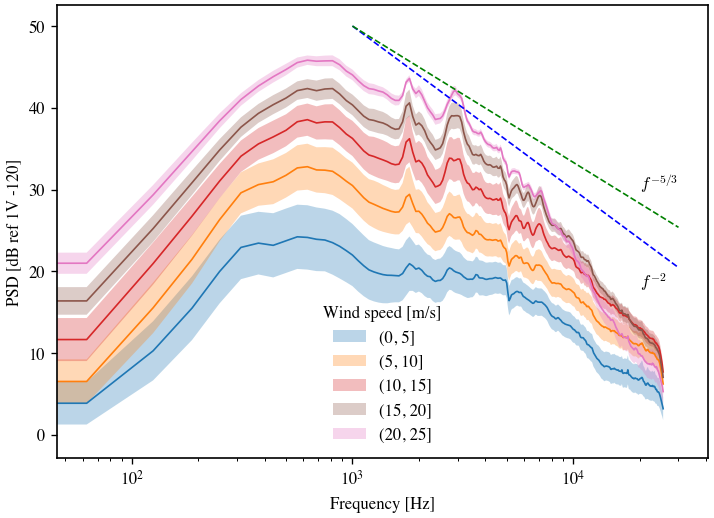

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

for bin in avg["wspd_bins"]:
    avg["spec"].sel(wspd_bins=bin).plot(ax=ax)
    ax.fill_between(
        avg.frqs,
        y1=(avg["spec"]-0.5*std["spec"]).sel(wspd_bins=bin),
        y2=(avg["spec"]+0.5*std["spec"]).sel(wspd_bins=bin),
        label=bin.values.astype("str"), alpha=0.3
    )
ax.set(xscale="log", title="", xlabel="Frequency [Hz]", ylabel="PSD [dB ref 1V -120]")
ax.legend(loc=0, title="Wind speed [m/s]")

_frqs = np.linspace(1E3,3E4)
ax.plot(_frqs, 10 * np.log10(_frqs**(-2)) + 110, color="blue", ls="--")
ax.plot(_frqs, 10 * np.log10(_frqs**(-5/3)) + 100, color="green", ls="--")
ax.text(2E4, 18, "$f^{-2}$")
ax.text(2E4, 30, "$f^{-5/3}$")

In [191]:
groups = ds.groupby_bins("wspd", np.arange(0,26,2))
avg = groups.mean()
std = groups.std()

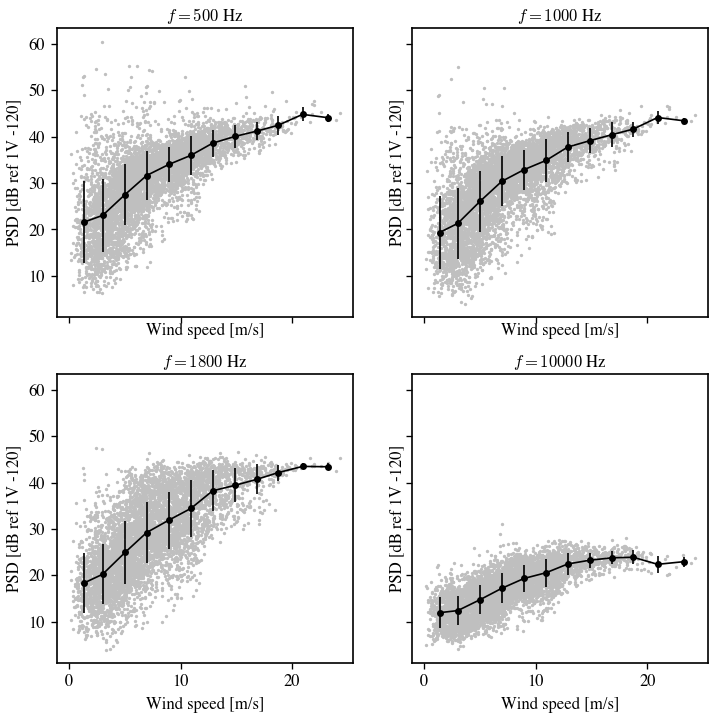

In [198]:
fig, ax = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
ax = ax.ravel()

for i, frq in enumerate([500, 1000, 1800, 10000]):
    ds.sel(frqs=frq, method="nearest").plot.scatter(ax=ax[i], x="wspd", y="spec", s=1, color="0.75")
    avg.sel(frqs=frq, method="nearest").plot.scatter(ax=ax[i], x="wspd", y="spec", s=10, color="k")
    ax[i].errorbar(
        avg["wspd"].values,
        avg["spec"].sel(frqs=frq, method="nearest").values,
        std["spec"].sel(frqs=frq, method="nearest").values,
        color="k"
    )
    ax[i].set(title=f"$f={frq}$ Hz", xlabel="Wind speed [m/s]", ylabel="PSD [dB ref 1V -120]")

In [195]:
avg.sel(frqs=1800, method="nearest")

<xarray.Dataset>
Dimensions:    (wspd_bins: 12)
Coordinates:
  * wspd_bins  (wspd_bins) object (0, 2] (2, 4] (4, 6] ... (20, 22] (22, 24]
    frqs       float64 1.812e+03
Data variables:
    spec       (wspd_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wspd       (wspd_bins) float64 1.384 3.018 5.023 6.95 ... 18.72 20.92 23.24
    wdir       (wspd_bins) float64 -7.853 -20.01 -11.06 ... 63.1 66.03 71.79